In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import math
from collections import Counter

from sklearn.linear_model import Lasso, LassoCV

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

The prices table is truncated this time to include stocks from our previous knowledge after running LASSO regression. We took a set of stocks from the past LASSO run, and then kept the ones which provided meaningful predictive ability - for example I removed stocks from the perfume industries (like Christian Dior), food retail industry (Costco) and liquor industry (like Kweichow Moutai) for this truncated LASSO analysis.  
  
This model does have look-ahead bias in that I have forward-looking knowledge of these set of stocks, but it's reasonable for me to say that with time, I can always acquire this knowledge and add to my collection of stocks to build better LASSO models with more educated prior knowledge on which stocks to optimize with for each iteration. Also, I can make for saying that this doesn't necessarily have to come from look-ahead bias, as I can truncate the feature space/set of stocks to limit myself to those within the tech/adjacent supporting industries. Thus, I can argue that this selection of stocks could represent a more nuanced quanta-mental approach to pairs trading.

In [2]:
df_prices = pd.read_csv('top100cap_stock_prices.csv',parse_dates=['Date'],index_col='Date')
df_prices = df_prices[['AAPL', '005930.KS', '300750.SZ', '3690.HK', 'ADBE', 'ASML', 'AVGO', 'BABA', 'MA', 'NFLX', 'TMO']]
dates_list = ['2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01', 
              '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01', 
              '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01', 
              '2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01', '2023-01-01' ]
df_prices.head()

,AAPL,005930.KS,300750.SZ,3690.HK,ADBE,ASML,AVGO,BABA,MA,NFLX,TMO
Date,,,,,,,,,,,
2019-01-02,39.480000,38750.0,73.660004,41.200001,224.570007,156.300003,253.509995,136.699997,189.740005,267.660004,219.419998
2019-01-03,35.547501,37600.0,73.830002,41.250000,215.699997,147.679993,230.960007,130.600006,181.179993,271.200012,212.169998
2019-01-04,37.064999,37450.0,76.959999,44.000000,226.190002,154.070007,233.229996,139.750000,189.759995,297.570007,221.759995
2019-01-07,36.982498,38750.0,77.419998,45.450001,229.259995,157.589996,237.979996,143.100006,191.220001,315.339996,224.750000
2019-01-08,37.687500,38100.0,79.330002,43.900002,232.679993,156.429993,236.070007,146.789993,192.279999,320.269989,229.979996


Features selected by Lasso Regressor:

005930.KS
3690.HK
ADBE
Number of features selected: 3


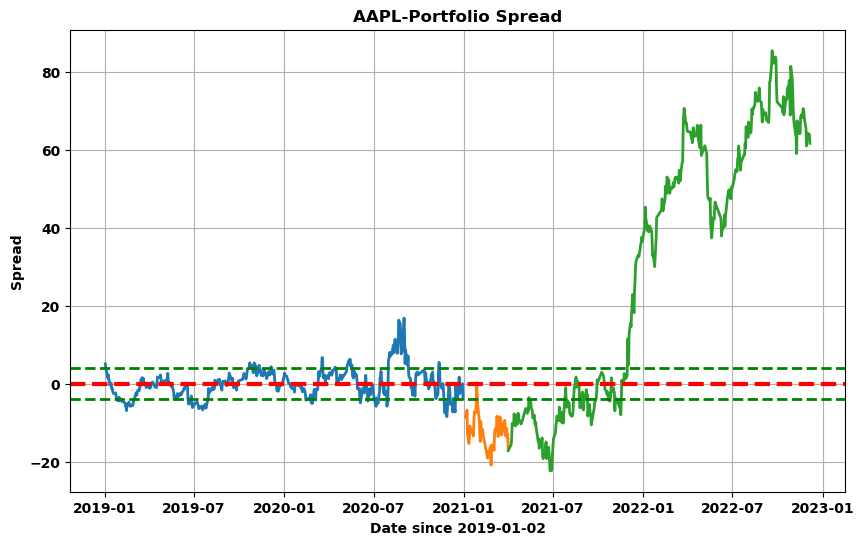

Features selected by Lasso Regressor:

005930.KS
Number of features selected: 1


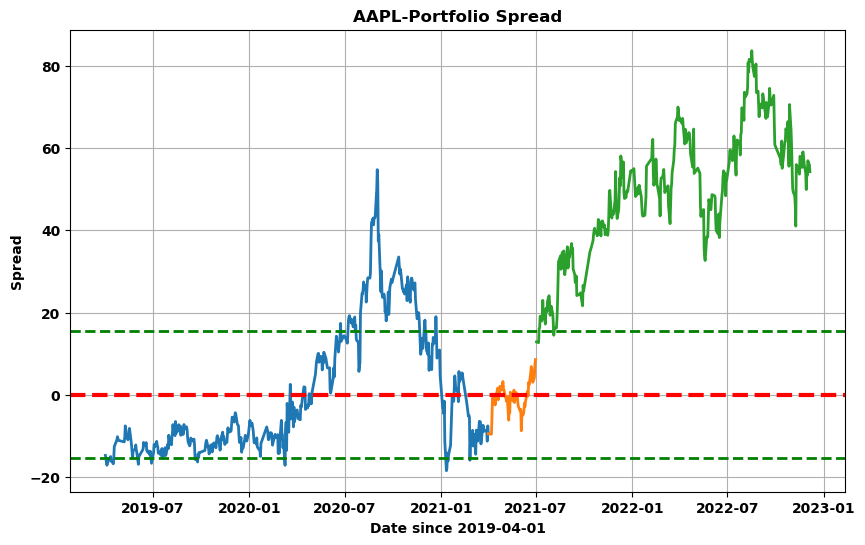

Features selected by Lasso Regressor:

005930.KS
3690.HK
ADBE
BABA
NFLX
TMO
Number of features selected: 6


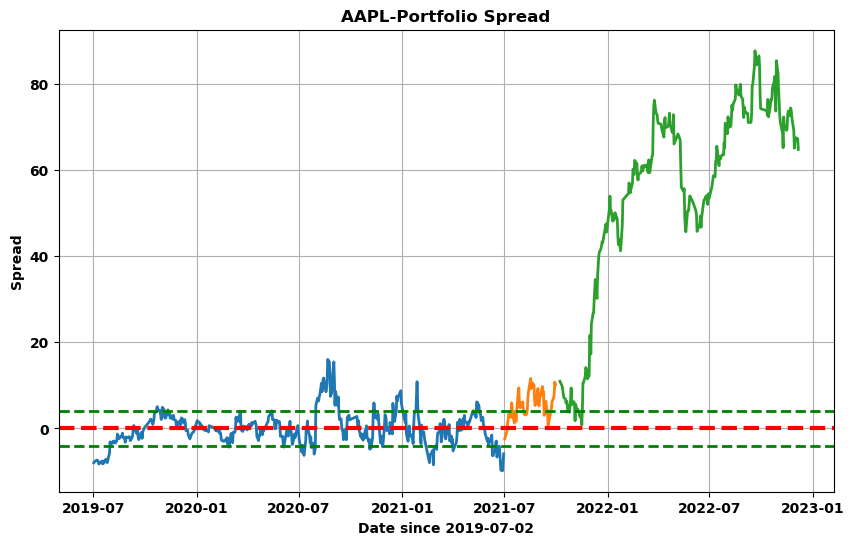

Features selected by Lasso Regressor:

005930.KS
3690.HK
ADBE
NFLX
TMO
Number of features selected: 5


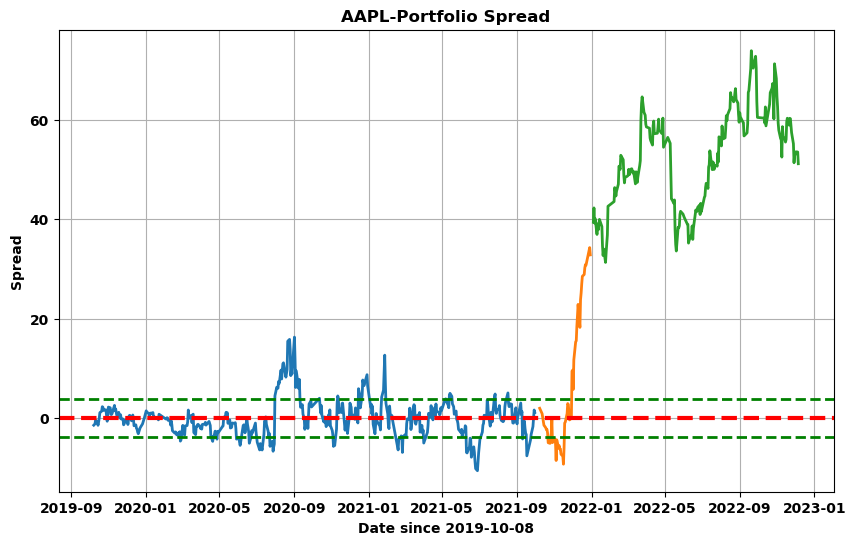

Features selected by Lasso Regressor:

005930.KS
3690.HK
ADBE
ASML
AVGO
TMO
Number of features selected: 6


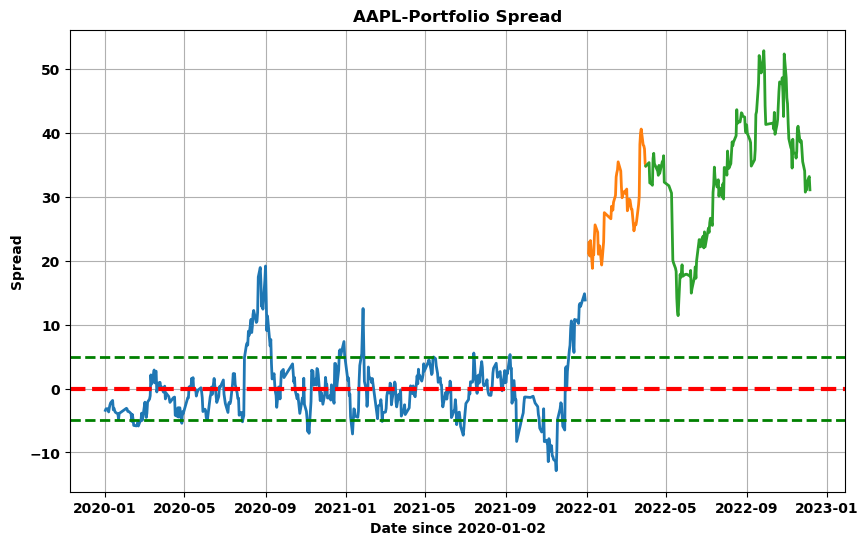

Features selected by Lasso Regressor:

005930.KS
ADBE
ASML
AVGO
MA
NFLX
TMO
Number of features selected: 7


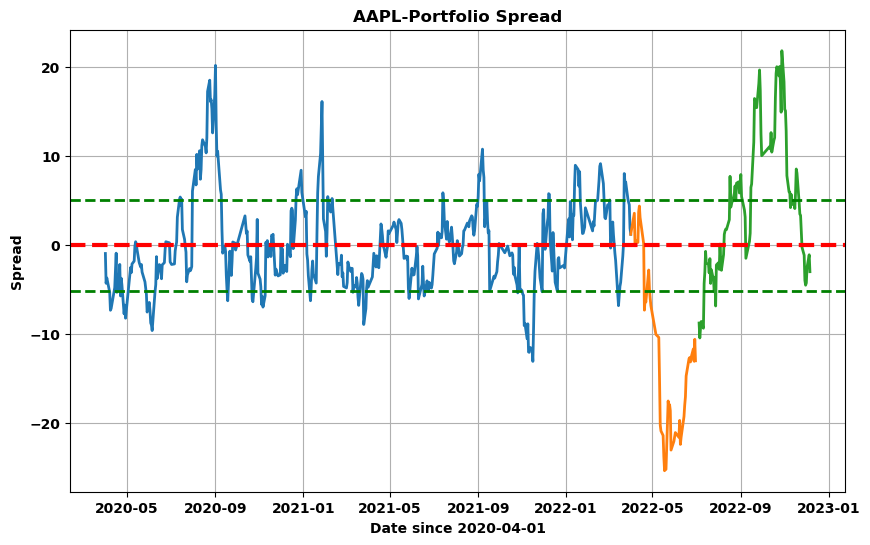

Features selected by Lasso Regressor:

005930.KS
300750.SZ
AVGO
TMO
Number of features selected: 4


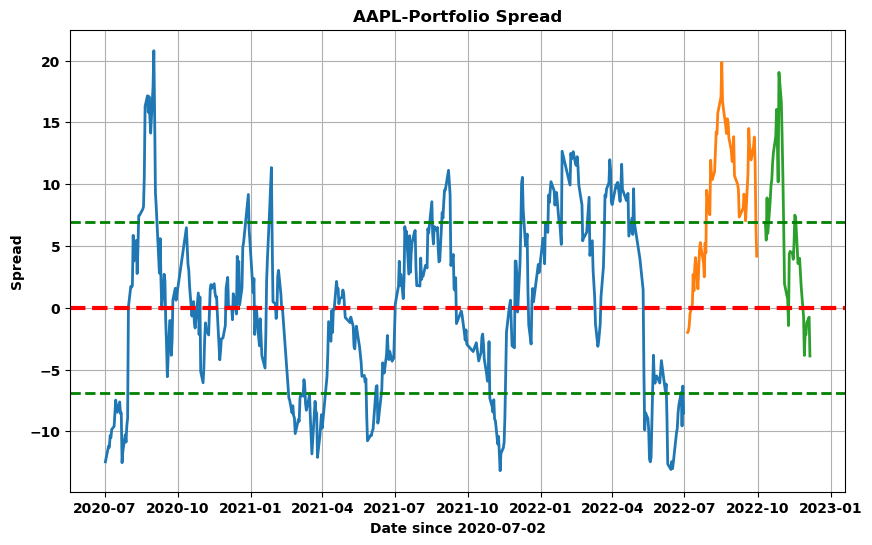

Features selected by Lasso Regressor:

005930.KS
300750.SZ
3690.HK
AVGO
TMO
Number of features selected: 5


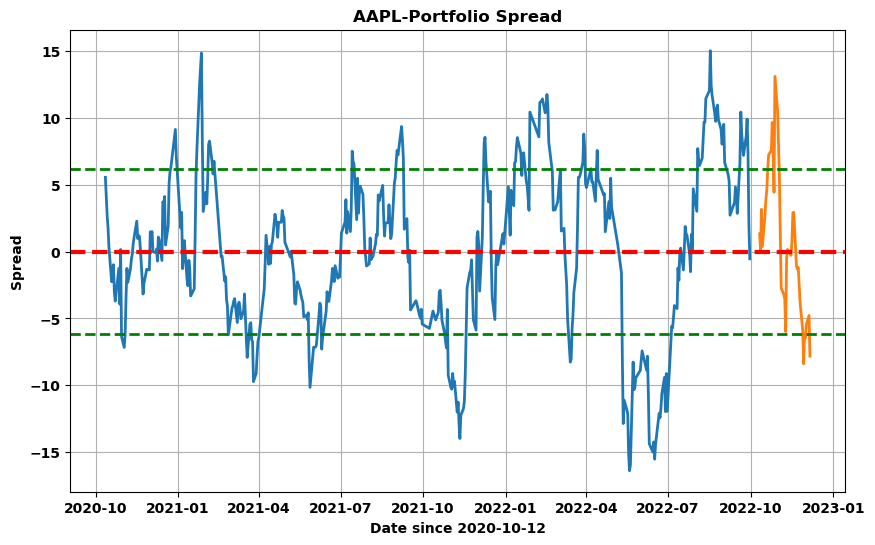

In [3]:
#each list corresponds to data for each OoS period
beta_list = [] #betas for use in analysis later on (for each OoS period)
features_selected_list = []
intercept_list = [] #intercept/beto-naught B0
train_spread_std_list = [] #standard deviation of spread from training data
train_normalized_spread_ceil_list = [] #to determine what ratio of portfolio to invest and what to hold in cash-heavy assets later on

for i in range(len(dates_list)-9): #12 months in-sample data, 3 months out-of-sample
    
    train_data = df_prices[dates_list[i]:dates_list[i+8]] #in-sample data
    test_data = df_prices[dates_list[i+8]:dates_list[i+9]] #out-of-sample data
    
    X_train = train_data.drop(['AAPL'],axis=1)
    y_train = train_data[['AAPL']]
    X_test = test_data.drop(['AAPL'],axis=1)
    y_test = test_data[['AAPL']]
    
    #first approximate nearest regularization power
    lasso_m = LassoCV(eps=1e-3, n_alphas=1000, cv=5).fit(X_train, y_train.values.ravel())
    #this tends to overtrain the (in my opinion based on training plots already overtrained) model
    #used to hone in on the best parameter value for regularization penalty
    reg_alpha = np.ceil(math.log10(lasso_m.alpha_))
    lambdas = np.arange(lasso_m.alpha_*1e-1, lasso_m.alpha_*1e1, lasso_m.alpha_*1e-2) #testing for all lambdas in the range [1e-5,1e-3] with a 1e-6 increment
    lasso_m = LassoCV(alphas=lambdas, cv=10, max_iter=10000).fit(X_train,y_train.values.ravel())
    beta_list.append(lasso_m.coef_)
    intercept_list.append(lasso_m.intercept_)
    
    print("Features selected by Lasso Regressor:\n")
    counter = 0 
    features_selected = []
    for index,coef_value in enumerate(lasso_m.coef_.tolist()):
        if coef_value != 0:
            print(str(X_train.columns[index]))
            features_selected.append(str(X_train.columns[index]))
            counter += 1
    print("Number of features selected:", counter)
    features_selected_list.append(features_selected)
    
    train_pred = lasso_m.predict(X_train)
    y_train['pred'] = train_pred

    train_spread = pd.DataFrame(y_train['AAPL'] - y_train['pred'],index=y_train.index,columns=['in-sample'])
    
    #store values for later use
    train_spread_mean = train_spread['in-sample'].mean() #=0
    train_spread_std = train_spread['in-sample'].std()
    train_spread_std_list.append(train_spread_std)
    
    train_spread_max_normed = train_spread['in-sample'].max() / train_spread['in-sample'].std()
    train_spread_min_normed = train_spread['in-sample'].min() / train_spread['in-sample'].std()
    abs_norm_spread_max = 1 + max(np.abs(train_spread_max_normed), np.abs(train_spread_min_normed))
    train_normalized_spread_ceil_list.append(np.ceil(abs_norm_spread_max))
    
    test_pred = lasso_m.predict(X_test)
    y_test['pred'] = test_pred
    test_spread = pd.DataFrame(y_test['AAPL'] - y_test['pred'],index=y_test.index,columns=['in-sample'])
    
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.grid(which='minor', linestyle=':', linewidth='0.5')
    plt.plot(train_spread,linewidth=2)
    plt.plot(test_spread,label='out of sample',linewidth=2)
    
    test_data2 = pd.DataFrame() #out-of-sample data2 extends 6-month oos horizon to exit any pending position
    if i+9 < len(dates_list)-1:
        test_data2 = df_prices[dates_list[i+9]:dates_list[len(dates_list)-1]]
        X_test2 = test_data2.drop(['AAPL'],axis=1)
        y_test2 = test_data2[['AAPL']]
        
        test_pred2 = lasso_m.predict(X_test2)
        y_test2['pred'] = test_pred2
        test_spread2 = pd.DataFrame(y_test2['AAPL'] - y_test2['pred'],index=y_test2.index,columns=['in-sample'])
        
        plt.plot(test_spread2,label='out of sample2',linewidth=2)
        
    plt.axhline(train_spread_mean, ls = '--', color='r',linewidth=3)
    plt.axhline(train_spread_mean + train_spread_std, ls = '--', color='g',linewidth=2)
    plt.axhline(train_spread_mean - train_spread_std, ls = '--', color='g',linewidth=2)
    plt.ylabel('Spread')
    plt.title('AAPL-Portfolio Spread')
    plt.xlabel('Date since ' + str(train_data.index[0])[:10])
    plt.show()
    plt.close()
    

In [4]:
df_oos = df_prices.copy().loc['2021-01-01':]
df_spread = pd.DataFrame(index=df_oos.index)
df_spread_norm = pd.DataFrame(index=df_oos.index)
# beta_list
# features_selected_list
# intercept_list
# train_spread_std_list
# train_normalized_spread_ceil_list
dates_list_oos = [
              '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01', 
              '2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01', '2023-01-01' ] #considers only OoS Sample dates

for i in range(len(dates_list_oos)-1):
    temp_df = df_oos.loc[dates_list_oos[i]:dates_list_oos[i+1]]
    temp_df_X = temp_df.drop(['AAPL'],axis=1)
    tickers = temp_df_X.columns
    beta = beta_list[i]
    pred = pd.DataFrame(index=temp_df.index)
    for j in range(len(beta)):
        weighted_stock = beta[j] * temp_df_X[[tickers[j]]]
        pred = pd.concat([ pred,weighted_stock ],axis=1)
    temp_df[dates_list_oos[i]] = temp_df['AAPL'] - pred.sum(axis=1) - intercept_list[i]
    df_spread[dates_list_oos[i]] = temp_df[dates_list_oos[i]]

for i in range(len(dates_list_oos)-1):
    df_spread_norm[dates_list_oos[i]] = df_spread[dates_list_oos[i]] / train_spread_std_list[i]

In [5]:
df_spread_norm.describe()

,2021-01-01,2021-04-01,2021-07-01,2021-10-01,2022-01-01,2022-04-01,2022-07-01,2022-10-01
count,56.000000,56.000000,59.000000,53.000000,54.000000,49.000000,59.000000,40.000000
mean,-3.041991,-0.022675,1.363310,1.647565,5.742434,-2.441772,1.297982,0.142914
std,0.977472,0.251255,0.733909,3.587804,1.150885,1.758020,0.782623,0.867627
min,-5.349445,-0.619358,-0.584913,-2.444379,3.799651,-4.951248,-0.288470,-1.355798
25%,-3.559275,-0.162932,0.856530,-1.157634,4.834976,-3.948930,0.658902,-0.534411
50%,-3.112912,-0.007443,1.350874,-0.062121,5.691450,-2.546248,1.443138,0.042582
75%,-2.409458,0.111527,1.862607,4.791363,6.345484,-1.175922,1.940750,0.724632
max,0.066636,0.556202,2.849545,9.011160,8.201559,0.861687,2.869480,2.116029


We observe that the maximum absolute normalized spread is as high as nine standard deviations for just the 3-month OoS period.

In [6]:
train_normalized_spread_ceil_list

[6.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 4.0]

In [7]:
df_oos = df_prices.copy().loc['2021-01-01':]
df_spread = pd.DataFrame(index=df_oos.index)
df_spread_norm = pd.DataFrame(index=df_oos.index)
# beta_list
# features_selected_list
# intercept_list
# train_spread_std_list
# train_normalized_spread_ceil_list

#we want to calculate the weighted portfolio in the for loop for each OoS model, and store it for future use in this variable
weighted_stock_ooS_models = pd.DataFrame(index=df_oos.index)

for i in range(len(dates_list_oos)-1):
    temp_df = df_oos.loc[dates_list_oos[i]:]
    temp_df_X = temp_df.drop(['AAPL'],axis=1)
    tickers = temp_df_X.columns
    beta = beta_list[i]
    pred = pd.DataFrame(index=temp_df.index)
    for j in range(len(beta)):
        weighted_stock = beta[j] * temp_df_X[[tickers[j]]]
        pred = pd.concat([ pred,weighted_stock ],axis=1)
    temp_df[dates_list_oos[i]] = temp_df['AAPL'] - pred.sum(axis=1) - intercept_list[i]
    df_spread[dates_list_oos[i]] = temp_df[dates_list_oos[i]]
    
    weighted_stock_OoS = pd.DataFrame(pred.sum(axis=1) + intercept_list[i],columns=[dates_list_oos[i]])
    weighted_stock_ooS_models = pd.concat([weighted_stock_ooS_models, weighted_stock_OoS],axis=1)

for i in range(len(dates_list_oos)-1):
    df_spread_norm[dates_list_oos[i]] = df_spread[dates_list_oos[i]] / train_spread_std_list[i]

In [8]:
weighted_stock_ooS_models

,2021-01-01,2021-04-01,2021-07-01,2021-10-01,2022-01-01,2022-04-01,2022-07-01,2022-10-01
Date,,,,,,,,
2021-01-04,137.783591,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,138.964744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,135.357573,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,137.714355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08,144.946481,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-11-30,85.296081,94.205409,81.212220,94.875355,116.770311,152.513575,150.083920,154.235895
2022-12-01,85.458814,94.944524,81.379551,95.254741,117.195907,152.541061,150.475646,154.770102
2022-12-02,83.520376,90.879388,80.285663,94.207674,115.392066,150.302179,149.025030,153.256399


In [9]:
df_spread_norm.describe()

,2021-01-01,2021-04-01,2021-07-01,2021-10-01,2022-01-01,2022-04-01,2022-07-01,2022-10-01
count,424.000000,369.000000,313.000000,254.000000,201.000000,148.000000,99.000000,40.000000
mean,6.388948,2.716195,11.218456,11.312662,6.563222,-0.169662,1.121091,0.142914
std,8.801300,1.504634,6.931646,5.708246,1.840221,2.281933,0.837274,0.867627
min,-5.711012,-0.619358,-0.584913,-2.444379,2.305900,-4.951248,-0.563971,-1.355798
25%,-2.059256,1.774116,2.413176,9.683595,5.159888,-1.682110,0.544111,-0.534411
50%,5.498263,3.116784,13.414476,13.149398,6.688545,0.007616,1.125128,0.042582
75%,15.290381,3.784709,17.286979,15.456982,7.847580,1.279126,1.819160,0.724632
max,21.830420,5.429992,21.512136,19.424542,10.676924,4.272797,2.869480,2.116029


As we observe here, the maximum absolute normalized spread goes to as high as over 21 units above standard deviation over time, showing that the model grows obsolete very quickly in the LASSO regression model beyond the 3-month prediction horizon. We repeat our old steps again to calculate our profits/losses from pairs trade this time.

In [10]:
for i in range(len(dates_list_oos)-1):
    df_spread_norm['lag '+dates_list_oos[i]] = df_spread_norm[dates_list_oos[i]].shift()
df_spread_norm

,2021-01-01,2021-04-01,2021-07-01,2021-10-01,2022-01-01,2022-04-01,2022-07-01,2022-10-01,lag 2021-01-01,lag 2021-04-01,lag 2021-07-01,lag 2021-10-01,lag 2022-01-01,lag 2022-04-01,lag 2022-07-01,lag 2022-10-01
Date,,,,,,,,,,,,,,,,
2021-01-04,-2.138968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,-2.031980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.138968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,-2.237055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.031980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,-1.735566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.237055,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08,-3.294306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.735566,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,16.024897,3.493067,16.383803,13.959706,6.309929,-0.876881,-0.296923,-1.001798,15.581020,3.239738,15.958984,13.498071,6.208306,-0.771363,-0.557437,-1.355798
2022-12-01,16.054852,3.463272,16.411429,13.933604,6.280539,-0.827495,-0.313074,-1.042834,16.024897,3.493067,16.383803,13.959706,6.309929,-0.876881,-0.296923,-1.001798
2022-12-02,16.422289,3.694639,16.557051,14.077277,6.543726,-0.487411,-0.175650,-0.879195,16.054852,3.463272,16.411429,13.933604,6.280539,-0.827495,-0.313074,-1.042834


In [11]:
# tickers
# beta_list
# train_spread_std_list
# train_normalized_spread_ceil_list

date_action_list = []
for i in range(len(dates_list_oos)-1):
    
    temp_df = df_spread_norm[['lag '+dates_list_oos[i], dates_list_oos[i]]]
    temp_df = temp_df.dropna(axis=0)
    
    should_i_trade = True
    if date_action_list: #if date_action_list is not empty
        
        #check if most recent action already exceeds the start date of this OoS sample, 
        #if so we need to start at later time to avoid excess leverage
        most_recent_action_date = date_action_list[len(date_action_list)-1][0]
        most_recent_action_type = date_action_list[len(date_action_list)-1][1]
        
        if most_recent_action_type == 0:
            #most recent reversion occurs after start of OoS date range, so take no new action till that date
            if most_recent_action_date > temp_df.index[0]: 
                while most_recent_action_date != temp_df.index[0]:
                    temp_df = temp_df.drop(str(temp_df.index[0])[:10],axis=0)
        
        #that means that we have taken a previous position and haven't closed it due to lack of signal, 
        #so do not make any new trades
        if most_recent_action_type != 0:
            should_i_trade = False
    
    reverted_status = True
    while len(temp_df!=0) and should_i_trade: #we will examine each temp_df row-by-row
        
        if reverted_status == True: #if we are not trading already
            
            #explore adding new position only if OoS sample is within 3 months, otherwise we move on to next 3-month OLS model
            if temp_df.index[0] < pd.Timestamp(dates_list_oos[i+1]):
            
                first_spread = temp_df.iat[(0,1)]
                #if absolute value >1 stdev for OoS spread and less than max observed norm spread from training, 
                #record date and entry position
                if np.abs(first_spread) > 1 and \
                np.abs(first_spread) < max(train_normalized_spread_ceil_list[:i+1]): 
                    date_action_list.append( (temp_df.index[0], np.sign(first_spread)) )
                    reverted_status = False
            
        else: #we are in a pairs-trade position, and need to check if it's time to close position
            
            compare_row = temp_df.iloc[0].tolist()

            if temp_df.index[0] < pd.Timestamp(dates_list_oos[i+1]): #check if position is open before next OoS period
            
                #if exceed max(train_normalized_spread_ceil_list) upto time t/i standard deviations on normalized spread, 
                #exit (book major loss)
                if np.abs(compare_row[0]) > max(train_normalized_spread_ceil_list[:i+1]): 
                    date_action_list.append( (temp_df.index[0], 0) )
                    reverted_status = True
                    temp_df = temp_df.drop(str(temp_df.index[0])[:10],axis=0)
                    continue #i.e. skip to start of while loop

                #this only happens if the prev/current spread sign changes, i.e. -/+ or +/-
                if sum(np.sign(compare_row)) == 0:
                    date_action_list.append( (temp_df.index[0], 0) )
                    reverted_status = True
            
            else: #position is open after next OoS period has started
                
                #exit position to book loss if normalized spread exceeds max(train_normalized_spread_ceil_list) upto time t/i
                if np.abs(compare_row[0]) > max(train_normalized_spread_ceil_list[:i+1]): 
                    date_action_list.append( (temp_df.index[0], 0) )
                    reverted_status = True
                    temp_df = temp_df.drop(str(temp_df.index[0])[:10],axis=0)
                    continue #i.e. skip to start of while loop
                
                #exit position if absolute normalized spread is within 0.25
                if np.abs(compare_row[0]) < 0.25: 
                    date_action_list.append( (temp_df.index[0], 0) )
                    reverted_status = True
            
        temp_df = temp_df.drop(str(temp_df.index[0])[:10],axis=0)

In [12]:
np.ceil(len(date_action_list)/2)

10.0

In [13]:
np.floor(len(date_action_list)/2)

9.0

In [14]:
date_action_list

[(Timestamp('2021-01-05 00:00:00'), -1.0),
 (Timestamp('2021-01-27 00:00:00'), 0),
 (Timestamp('2021-01-29 00:00:00'), -1.0),
 (Timestamp('2021-08-19 00:00:00'), 0),
 (Timestamp('2021-08-19 00:00:00'), 1.0),
 (Timestamp('2021-11-17 00:00:00'), 0),
 (Timestamp('2021-11-17 00:00:00'), -1.0),
 (Timestamp('2021-11-22 00:00:00'), 0),
 (Timestamp('2021-11-30 00:00:00'), 1.0),
 (Timestamp('2021-12-13 00:00:00'), 0),
 (Timestamp('2022-01-05 00:00:00'), 1.0),
 (Timestamp('2022-02-15 00:00:00'), 0),
 (Timestamp('2022-03-04 00:00:00'), 1.0),
 (Timestamp('2022-03-23 00:00:00'), 0),
 (Timestamp('2022-04-20 00:00:00'), -1.0),
 (Timestamp('2022-07-15 00:00:00'), 0),
 (Timestamp('2022-07-29 00:00:00'), 1.0),
 (Timestamp('2022-11-08 00:00:00'), 0),
 (Timestamp('2022-11-29 00:00:00'), -1.0)]

A lot of trading actions take place, and this time based on what we saw from the plots earlier, we can expect some heavy losses as well. In total, 10 positions were taken, with 9 positions closed and one still open at the end of the time period.

In [15]:
action_dates, action_type = zip(*date_action_list)
action_dates = [str(i)[:10] for i in action_dates]

In [16]:
df_execution_days = pd.concat([df_oos[['AAPL']],weighted_stock_ooS_models],axis=1)
df_execution_days = df_execution_days.shift(-1).loc[action_dates] #shift up because we act on next day's price
df_execution_days['action type'] = action_type

df_execution_days['AAPL ownership'] = (df_execution_days['action type']*-100) / df_execution_days['AAPL']

df_execution_days['Portfolio ownership'] = np.nan
res_list = []
for i in range(len(dates_list_oos)-1):
     
    df_execution_days_temp = df_execution_days[dates_list_oos[i]:dates_list_oos[i+1]]
    
    if not df_execution_days_temp.empty:
        df_execution_days_temp['Portfolio ownership'] = (df_execution_days_temp['action type']*100) / df_execution_days_temp[dates_list_oos[i]]
        res_list.append(df_execution_days_temp['Portfolio ownership'].values.tolist())
flat_list = [item for sublist in res_list for item in sublist]
df_execution_days['Portfolio ownership'] = flat_list

df_execution_days['AAPL ownership shift'] = df_execution_days['AAPL ownership'].shift()
df_execution_days['Portfolio ownership shift'] = df_execution_days['Portfolio ownership'].shift()
arb_ret_list = []
for i in range(len(dates_list_oos)-1):
     
    df_execution_days_temp = df_execution_days[dates_list_oos[i]:dates_list_oos[i+1]]
    
    if not df_execution_days_temp.empty:
        df_execution_days_temp['arbitrage returns'] = \
        df_execution_days_temp['AAPL']*df_execution_days_temp['AAPL ownership shift'] + \
        df_execution_days_temp[dates_list_oos[i]]*df_execution_days_temp['Portfolio ownership shift'] 
        arb_ret_list.append(df_execution_days_temp['arbitrage returns'].values.tolist())
arb_ret_flat_list = [item for sublist in arb_ret_list for item in sublist]
df_execution_days['arbitrage returns'] = arb_ret_flat_list

df_execution_days

,AAPL,2021-01-01,2021-04-01,2021-07-01,2021-10-01,2022-01-01,2022-04-01,2022-07-01,2022-10-01,action type,AAPL ownership,Portfolio ownership,AAPL ownership shift,Portfolio ownership shift,arbitrage returns
Date,,,,,,,,,,,,,,,
2021-01-05,126.599998,135.357573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.789889,-0.738784,NaN,NaN,NaN
2021-01-27,137.089996,140.381128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.000000,0.000000,0.789889,-0.738784,4.574617
2021-01-29,134.139999,143.456328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.745490,-0.697076,-0.000000,0.000000,0.000000
2021-08-19,148.190002,147.556012,113.607195,137.591792,NaN,NaN,NaN,NaN,NaN,0.0,-0.000000,0.000000,0.745490,-0.697076,14.562162
2021-08-19,148.190002,147.556012,113.607195,137.591792,NaN,NaN,NaN,NaN,NaN,1.0,-0.674809,0.726788,-0.000000,0.000000,0.000000
2021-11-17,157.869995,157.020423,108.987722,147.298560,158.894719,NaN,NaN,NaN,NaN,0.0,-0.000000,0.000000,-0.674809,0.726788,8.950553
2021-11-17,157.869995,157.020423,108.987722,147.298560,158.894719,NaN,NaN,NaN,NaN,-1.0,0.633433,-0.629348,-0.000000,0.000000,0.000000
2021-11-22,161.410004,158.839821,118.411447,147.266941,158.508966,NaN,NaN,NaN,NaN,0.0,-0.000000,0.000000,0.633433,-0.629348,2.485130
2021-11-30,164.770004,155.014580,116.748437,143.415905,155.151235,NaN,NaN,NaN,NaN,1.0,-0.606907,0.644532,-0.000000,0.000000,0.000000


In [17]:
df_execution_days[['arbitrage returns']].iloc[1::2].describe()

,arbitrage returns
count,9.000000
mean,2.157626
std,8.249795
min,-8.799803
25%,-5.879772
50%,3.969965
75%,8.121501
max,14.562162


In [18]:
#returns if negative values/major losses are excluded
df_execution_days[df_execution_days['arbitrage returns']>0][['arbitrage returns']].sum()

arbitrage returns    42.663928
dtype: float64

In [19]:
#true return
df_execution_days['arbitrage returns'].sum()

19.41863427546788

On a $100 long/short into AAPL or Portfolio at an appropriate time, based on predictions from our LASSO model, our results reveal that this strategy returns a better performance than simple pairs trade between AAPL/MSFT and AAPL/Samsung. We also see that the maximum loss was huge for some positions (in the few cases when model failed to model the deviation in spread accurately), and the number of trades made were more compared to simple pairs trading.  
  
By having some prior knowledge of which stocks provide meaningful predictive ability to the our model, we are able to more effectively utilize LASSO regression to improve on the original pairs-trading strategy. Thus, LASSO regression should be utilized on a set of stocks first, using which we should identify the subset of stocks that surface regularly over multiple periods of time. Then, by retraining our LASSO model on the curtailed set of stocks selected based on the first series of LASSO models after removing the ones that we decide are not relevant to the industry concerned, we can focus on optimizing the training algorithm for just the remaining set of stocks which seems to have some improvement in predictive ability compared to simple pairs trading.

Finally, we do an analysis of the features selected by the LASSO model across each of the eight out-of-sample periods to see which names showed up most often, and if anything meaningful can be drawn from that:

In [20]:
features_selected_flat_list = [item for sublist in features_selected_list for item in sublist]

In [21]:
Counter(features_selected_flat_list)

Counter({'005930.KS': 8,
         '3690.HK': 5,
         'ADBE': 5,
         'BABA': 1,
         'NFLX': 3,
         'TMO': 6,
         'ASML': 2,
         'AVGO': 4,
         'MA': 1,
         '300750.SZ': 2})